In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 542.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00


# Setup Libraries

In [2]:
import tempfile
import os
import math
import calendar
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Setup Data

In [155]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [261]:
train_X_np = np.load('/content/drive/My Drive/ERA5 Data/data/spei_training_data_2001/train_X.npy')
print(np.isnan(train_X_np).sum(), np.sum(train_X_np <= -9999))
print(train_X_np.shape)

0 679261
(143981, 13)


In [262]:
mask = np.all(train_X_np > -9999.0, axis=1)
clean_X = train_X_np[mask]

In [263]:
mean_X = np.nanmean(clean_X, axis=0)
mean_X

array([ 2.9078937e+02,  2.8281781e+02,  2.7345538e+02,  3.0185541e+02,
        2.9231519e+02,  2.8404886e+02, -6.9236182e-02,  3.0814847e+02,
        2.9386923e+02,  2.8473819e+02,  3.2706354e+02,  1.5085346e+04,
        4.9258523e-02], dtype=float32)

In [264]:
clean_X.shape

(66244, 13)

In [265]:
std_X = np.nanstd(clean_X, axis=0)
std_X

array([4.7537932e+00, 5.7318058e+00, 7.1890616e+00, 8.5383997e+00,
       6.3102584e+00, 6.4265013e+00, 5.1384334e-02, 1.5265549e+01,
       7.2404723e+00, 7.1335526e+00, 1.4782816e+02, 7.7059404e+03,
       6.5183483e-02], dtype=float32)

In [266]:
clean_X = (clean_X - mean_X) / (std_X + 1e-8)

In [267]:
def plot_histogram(data, x_lab, title):
  fig, ax = plt.subplots(figsize=(8, 6))

  ax.hist(
      data,
      bins=30,
      alpha=0.75,
      edgecolor='black',
      linewidth=1
  )

  ax.set_title(title, fontsize=18, weight='bold')
  ax.set_xlabel(x_lab, fontsize=14)
  ax.set_ylabel('Frequency', fontsize=14)

  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
  fig.tight_layout()

  plt.show()

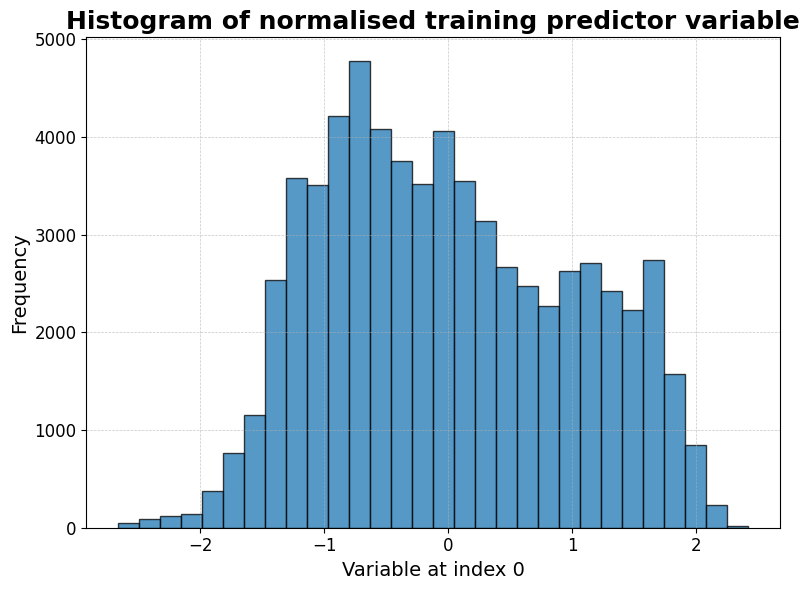

In [268]:
plot_histogram(clean_X[:, 0], 'Variable at index 0', 'Histogram of normalised training predictor variable')

In [269]:
train_y_np = np.load('/content/drive/My Drive/ERA5 Data/data/spei_training_data_2001/train_y.npy')
print(np.isnan(train_y_np).sum(), np.sum(train_y_np <= -9999))
print(train_y_np.shape)

0 22517
(143981, 1)


In [270]:
clean_y = train_y_np[mask]

In [271]:
clean_y.shape

(66244, 1)

In [272]:
mean_y = np.nanmean(clean_y, axis=0)
mean_y

array([0.05907987], dtype=float32)

In [273]:
std_y = np.nanstd(clean_y, axis=0)
std_y

array([1.0165229], dtype=float32)

In [274]:
clean_y = (clean_y - mean_y) / (std_y + 1e-8)

# SPEI Model

In [224]:
def build_pixel_mlp(n_features=4):
    """
    Builds a simple feed-forward (MLP) network that maps
      (n_features,) → SPEI-01 scalar.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(n_features,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(1, activation='linear')  # SPEI-01 output
    ])
    return model

In [228]:
model = build_pixel_mlp(n_features=13)
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_55 (Dense)                │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,593 (432.00 KB)

 Trainable params: 110,593 (432.00 KB)

 Non-trainable params: 0 (0.00 B)

In [229]:
model.compile(
    optimizer='adam',
    loss='mae',
    metrics=['mse']
)

In [275]:
history = model.fit(
    clean_X, clean_y,
    epochs=40,
    batch_size=128
)

Epoch 1/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1536 - mse: 0.0467
Epoch 2/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1537 - mse: 0.0470
Epoch 3/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1528 - mse: 0.0465
Epoch 4/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1532 - mse: 0.0465
Epoch 5/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1524 - mse: 0.0456
Epoch 6/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1521 - mse: 0.0451
Epoch 7/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1513 - mse: 0.0452
Epoch 8/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1512 - mse: 0.0448
Epoch 9/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1534 - mse: 0.0468
Epoch 10/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1524 - mse: 0.0460
Epoch 11/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1501 - mse: 0.0445
Epoch 12/40
518/518 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1514 - mse: 0.0451
Epoch 13/40
518/518 ━━━━━

In [276]:
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/spei_earthformer_T1_2001_C1.keras')
model.save('/content/drive/My Drive/ERA5 Data/data/training data 2001/spei_earthformer_T1_2001_C1.h5')

In [233]:
model.load_weights('/content/drive/My Drive/ERA5 Data/data/training data 2001/spei_earthformer_T1_2001_C1.h5')

# 2 Stage Model Test

In [277]:
test_X_np = np.load('/content/drive/My Drive/ERA5 Data/data/spei_test_data_2002/test_X.npy')
print(np.isnan(test_X_np).sum(), np.sum(test_X_np <= -9999))
print(test_X_np.shape)

0 0
(142704, 13)


In [278]:
test_y_np = np.load('/content/drive/My Drive/ERA5 Data/data/spei_test_data_2002/test_y.npy')
print(np.isnan(test_y_np).sum(), np.sum(test_y_np <= -9999))
print(test_y_np.shape)

0 22517
(142704, 1)


In [279]:
mask = np.all((test_X_np > -9999.0) & (test_y_np > -9999.0), axis=1)
clean_X = test_X_np[mask]

In [280]:
clean_X.shape

(120187, 13)

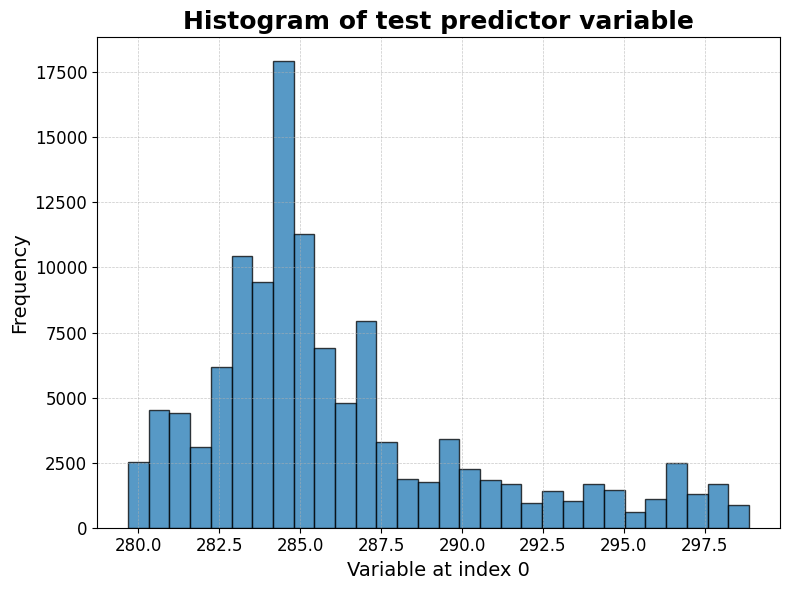

In [281]:
plot_histogram(clean_X[:, 0], 'Variable at index 0', 'Histogram of test predictor variable')

In [282]:
clean_X = (clean_X - mean_X) / (std_X + 1e-8)

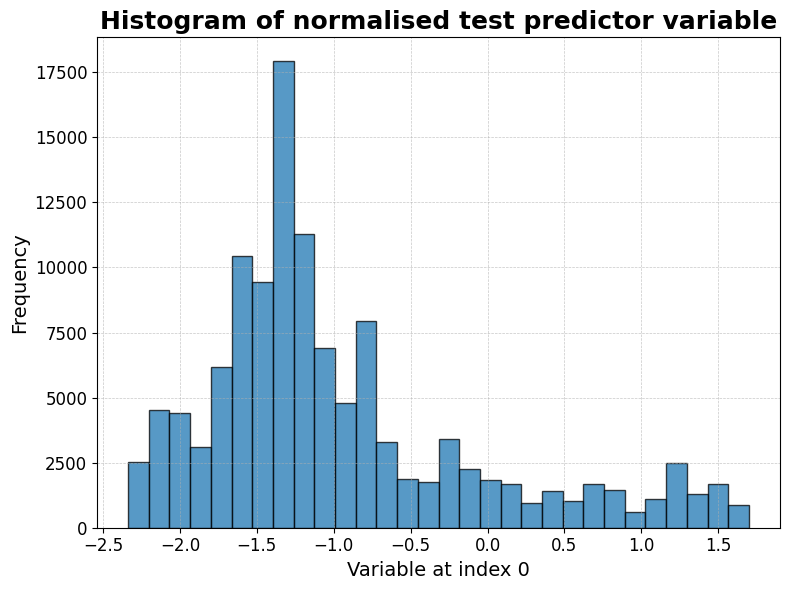

In [283]:
plot_histogram(clean_X[:, 0], 'Variable at index 0', 'Histogram of normalised test predictor variable')

In [284]:
clean_y = test_y_np[mask]

In [285]:
clean_y.shape

(120187, 1)

In [286]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [289]:
y_pred = model.predict(clean_X)

3756/3756 ━━━━━━━━━━━━━━━━━━━━ 3s 871us/step


In [290]:
y_pred = y_pred * (std_y + 1e-8) + mean_y

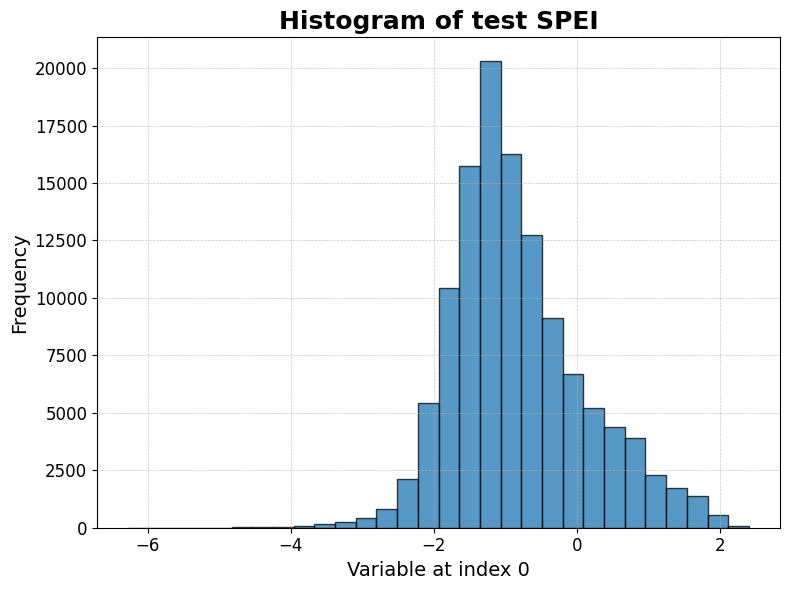

In [291]:
plot_histogram(clean_y[:, 0], 'Variable at index 0', 'Histogram of test SPEI')

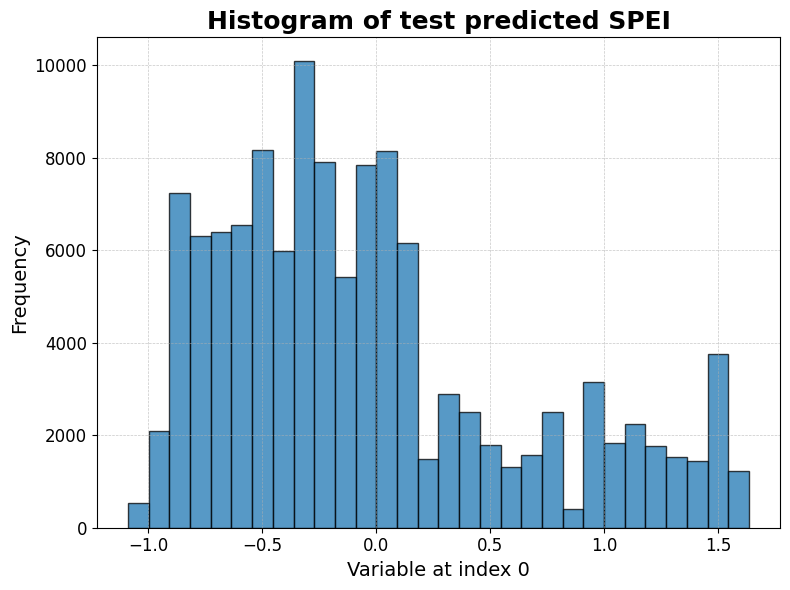

In [292]:
plot_histogram(y_pred, 'Variable at index 0', 'Histogram of test predicted SPEI')

In [293]:
y_true = clean_y

In [294]:
def compute_all_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    y_true_clean = y_true_flat
    y_pred_clean = y_pred_flat

    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)

    nse_numerator = np.sum((y_true_clean - y_pred_clean) ** 2)
    nse_denominator = np.sum((y_true_clean - np.mean(y_true_clean)) ** 2)
    nse = 1 - (nse_numerator / nse_denominator)

    if len(y_true_clean) > 1:
        true_diff = np.diff(y_true_clean)
        pred_diff = np.diff(y_pred_clean)
        trend_agreement = np.sign(true_diff) == np.sign(pred_diff)
        trend_accuracy = np.mean(trend_agreement)
    else:
        trend_accuracy = np.nan

    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
        "NSE": nse,
        "Trend Accuracy (%)": trend_accuracy * 100
    }


In [295]:
def print_metrics(metrics_dict, title="Test Set Metrics"):
    print(f"\n{title}:")
    print("-" * (len(title) + 1))
    for k, v in metrics_dict.items():
        if isinstance(v, (np.float32, np.float64, float)):
            print(f"{k:20}: {v:.4f}")
        else:
            print(f"{k:20}: {v}")

In [296]:
metrics = compute_all_metrics(y_true, y_pred)
print_metrics(metrics)


Test Set Metrics:
-----------------
MAE                 : 1.0544
RMSE                : 1.2799
R2                  : -0.9013
NSE                 : -0.9013
Trend Accuracy (%)  : 12.8958
